In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import keras

C:\Users\Shubham\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Shubham\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Shubham\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Shubham\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

In [2]:
df = pd.read_csv('SBIN.NS.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,254.649994,269.750000,254.300003,263.200012,263.200012,71202072.0
1,2018-05-24,263.850006,269.700012,260.649994,268.500000,268.500000,34679642.0
2,2018-05-25,267.799988,268.399994,262.549988,266.950012,266.950012,22317308.0
3,2018-05-28,267.399994,274.200012,266.049988,272.049988,272.049988,18959368.0
4,2018-05-29,270.500000,270.950012,262.799988,264.299988,264.299988,16107543.0


### we need to need drop the NA values because if not the loss and val_loss in the fit method will give us Nan as output

In [4]:
df = df.dropna()

In [5]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [7]:
#Variables for training
cols = list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [8]:
df_for_training = df[cols].astype(float)
df_for_training.head()

,Open,High,Low,Close,Adj Close
0,254.649994,269.750000,254.300003,263.200012,263.200012
1,263.850006,269.700012,260.649994,268.500000,268.500000
2,267.799988,268.399994,262.549988,266.950012,266.950012
3,267.399994,274.200012,266.049988,272.049988,272.049988
4,270.500000,270.950012,262.799988,264.299988,264.299988


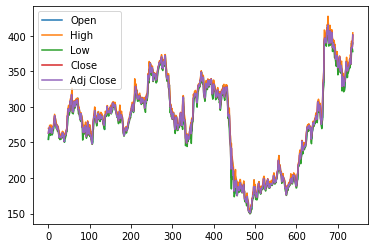

In [9]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [10]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [11]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

In [12]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

In [13]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

in the above code we will be taking the 14(0 to 13) rows as the independent values and 14th row as dependent value than shifting one index ahead ie. 1 to 14 as independent values and 15th values as a dependent value in trainX and trainY resp 

In [14]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [15]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (722, 14, 5).
trainY shape == (722, 1).


the shape says: trainX has 724 values 14 rows and 5 columns and trainY has 724 values and 1 column

### AUTO ENCODER MDOEL

In [16]:
#Needed to downgarade the np version because the NN layers were giving an error saying Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array

#!pip install numpy==1.19.4

In [17]:
np.__version__

'1.19.4'

In [18]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(14, 5), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [19]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
41/41 [==============================] - 7s 51ms/step - loss: 0.3523 - val_loss: 1.1181
Epoch 2/10
41/41 [==============================] - 1s 18ms/step - loss: 0.0806 - val_loss: 0.1729
Epoch 3/10
41/41 [==============================] - 1s 18ms/step - loss: 0.0610 - val_loss: 0.4532
Epoch 4/10
41/41 [==============================] - 1s 18ms/step - loss: 0.0560 - val_loss: 0.3135
Epoch 5/10
41/41 [==============================] - 1s 18ms/step - loss: 0.0460 - val_loss: 0.2489
Epoch 6/10
41/41 [==============================] - 1s 18ms/step - loss: 0.0365 - val_loss: 0.0883
Epoch 7/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0408 - val_loss: 0.1120
Epoch 8/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0324 - val_loss: 0.1352
Epoch 9/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0381 - val_loss: 0.1962
Epoch 10/10
41/41 [==============================] - 1s 19ms/step - loss: 0.0384 - val_loss: 0.0673


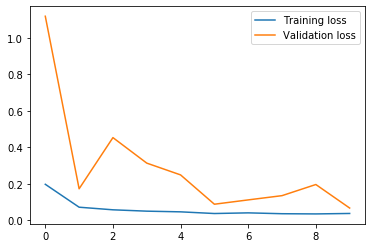

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [28]:
list(train_dates)[2]

Timestamp('2018-05-25 00:00:00')

In [23]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
733,2021-05-17,364.399994,385.200012,363.649994,383.100006,383.100006,106555796.0
734,2021-05-18,390.000000,392.549988,380.049988,382.250000,382.250000,70917710.0
735,2021-05-19,382.000000,389.500000,381.200012,384.399994,384.399994,48189573.0
736,2021-05-20,387.000000,387.799988,382.000000,384.549988,384.549988,42898608.0
737,2021-05-21,390.000000,404.399994,378.000000,401.200012,401.200012,192810772.0


In [49]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [50]:
forecast_period_dates

[Timestamp('2021-05-21 00:00:00', freq='D'),
 Timestamp('2021-05-22 00:00:00', freq='D'),
 Timestamp('2021-05-23 00:00:00', freq='D'),
 Timestamp('2021-05-24 00:00:00', freq='D'),
 Timestamp('2021-05-25 00:00:00', freq='D'),
 Timestamp('2021-05-26 00:00:00', freq='D'),
 Timestamp('2021-05-27 00:00:00', freq='D'),
 Timestamp('2021-05-28 00:00:00', freq='D'),
 Timestamp('2021-05-29 00:00:00', freq='D'),
 Timestamp('2021-05-30 00:00:00', freq='D'),
 Timestamp('2021-05-31 00:00:00', freq='D'),
 Timestamp('2021-06-01 00:00:00', freq='D'),
 Timestamp('2021-06-02 00:00:00', freq='D'),
 Timestamp('2021-06-03 00:00:00', freq='D'),
 Timestamp('2021-06-04 00:00:00', freq='D'),
 Timestamp('2021-06-05 00:00:00', freq='D'),
 Timestamp('2021-06-06 00:00:00', freq='D'),
 Timestamp('2021-06-07 00:00:00', freq='D'),
 Timestamp('2021-06-08 00:00:00', freq='D'),
 Timestamp('2021-06-09 00:00:00', freq='D'),
 Timestamp('2021-06-10 00:00:00', freq='D'),
 Timestamp('2021-06-11 00:00:00', freq='D'),
 Timestamp

In [51]:
-n_future

-90

In [52]:
forecast = model.predict(trainX[-n_future:]) #forecast

In [53]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0] #all rows and only 1 column ie. 0th

In [54]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [55]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [56]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-01-01'] #date to start the visualization from so that the graph is seen clearly zoomed

C:\Users\Shubham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\Shubham\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Shubham\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


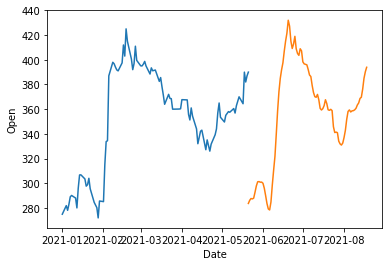

In [57]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

## FBPROPHET

In [68]:
from fbprophet import Prophet

In [59]:
df2 = df.reset_index()[['Date', 'Open']].rename({'Date':'ds', 'Open':'y'}, axis='columns')

In [60]:
df2.head()

,ds,y
0,2018-05-23,254.649994
1,2018-05-24,263.850006
2,2018-05-25,267.799988
3,2018-05-28,267.399994
4,2018-05-29,270.500000


In [61]:
df2.tail()

,ds,y
731,2021-05-17,364.399994
732,2021-05-18,390.000000
733,2021-05-19,382.000000
734,2021-05-20,387.000000
735,2021-05-21,390.000000


In [65]:
train = df2[(df2['ds'] >= '2018-05-23') & (df2['ds'] <= '2021-01-23')]
test =  df2[(df2['ds'] > '2021-01-23')]

In [66]:
train.shape

(658, 2)

In [73]:
test.shape

(78, 2)

In [69]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [70]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
m.params

OrderedDict([('k', array([[0.53436142]])),
             ('m', array([[0.71541332]])),
             ('delta',
              array([[ 2.53931089e-08, -1.63918458e-07, -5.19253409e-01,
                      -4.88113548e-01, -1.05393668e-07,  8.07669657e-07,
                       4.86158239e-01,  1.36382079e+00,  2.38644665e-01,
                      -1.38038708e-07, -6.00914738e-01, -1.46921232e+00,
                      -3.85342022e-01,  4.06887127e-08,  3.81826680e-01,
                       4.38717153e-05, -1.18970656e-07, -2.85686011e-03,
                      -9.48388986e-01, -8.93243846e-01, -3.32289855e-08,
                       1.05653254e-02,  1.45873850e+00,  1.40594728e+00,
                       3.45813446e-01]])),
             ('sigma_obs', array([[0.04417826]])),
             ('beta',
              array([[ 5.63758952e-03,  3.77998022e-02,  1.72342440e-02,
                       5.44547216e-02, -3.61656077e-03,  2.15010054e-03,
                      -7.33808461e-03, -7.358

In [72]:
future1 = m.make_future_dataframe(periods = 78) #periods same as test row size
future1.tail()

,ds
731,2021-04-06
732,2021-04-07
733,2021-04-08
734,2021-04-09
735,2021-04-10


In [75]:
forecast = m.predict(future1)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
731,2021-04-06,265.890948,225.407612,307.707559
732,2021-04-07,266.432953,225.770660,308.438415
733,2021-04-08,268.027544,224.911493,310.285426
734,2021-04-09,268.145169,224.915261,310.602202
735,2021-04-10,260.132728,218.024468,302.120767


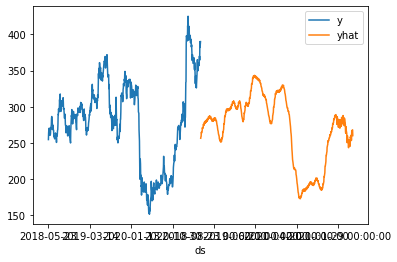

In [76]:
pd.concat([df2.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot()

C:\Users\Shubham\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Shubham\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


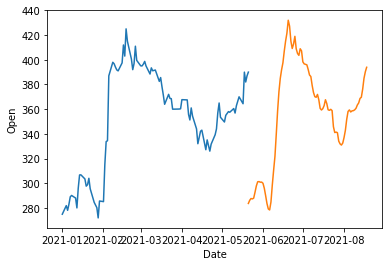

In [77]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])